# Code to implement the Computational graph and breaking down complex operations. We also learn to reverse traverse along an equation

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [32]:
class Value:
  
  def __init__(self, data,_children=(),_op='',label=''): #children is like pointer to point to what value produced it. it is initialized as empty tuple 
    self.data = data
    self._prev=set(_children) #maintained as set for efficiency
    self._op=_op #to know what operation produced it
    self.label=label
    self.grad=0.0
    self._backward= lambda: None #by default it is a function that doesnt do anything and returns none
  
  def __repr__(self): #this function runs when Value() is used in the program
    return f"Value(data={self.data})" #returns as a value object
  
  #Operation in value objects should be defined seperately
  def __add__(self, other): #python automatically calls this function if + is used between two value objects
    other=other if isinstance(other, Value) else Value(other) #if other is not a value object we wrap it into a value object
    out = Value(self.data + other.data,(self,other),'+') 
    
    def _backward(): #for an addition operation : the output's gradient is just copied to the operands' gradients. eg: if c=a+b , a.grad=1*c.grad and b.grad=1*c.grad
        self.grad+=1.0*out.grad #we use += to address the multivariate cases(same variable used multiple times)
        other.grad+=1.0*out.grad
    out._backward=_backward #we dont use _backward() because we are not calling the function which just returns none. instead we are storing the function
    return out

  def __mul__(self, other):
    other=other if isinstance(other,Value) else Value(other) #eg: if a*2 is run... 2 is not a vlaue obj so it is wrapped into a value obj
    out = Value(self.data * other.data,(self,other),'*')#(self,other) is the tuple for _prev
    
    def _backward(): # for multiplication operation, c=a*b: a's gradient is c's gradient times b; and b's gradient is c's gradient times a
        self.grad+=other.data*out.grad
        other.grad+=self.data*out.grad
    
    out._backward=_backward
    return out


  def tanh(self): #e^( 2 x) − 1 / e (2 x) + 1
    x=self.data
    t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
    out=Value(t,(self, ),'tanh') #(self,) is a tuple of  children
        
    def _backward():
        self.grad+=(1-t**2)*out.grad #d/dx(tanh)=1-(tanhx)^2
    out._backward=_backward
    return out
  
  def backward(self):
    #building topological graph
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)
    
    #reversing the topological graph. because we need to go from output to leaves.
    self.grad = 1.0
    for node in reversed(topo):
        node._backward()


In [35]:
#to visualize the expression

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [36]:
W1=Value(2.0,label='W1')
b1=Value(1.5,label='b1')
W2=Value(5.0,label='W2')
b2=Value(3.2,label='b2')
X=Value(2.4,label='X')
Z1=W1*X+b1
A1=Z1.tanh()
Z2=W2*A1+b2
A2=Z2.tanh()


In [37]:
A2.backward()

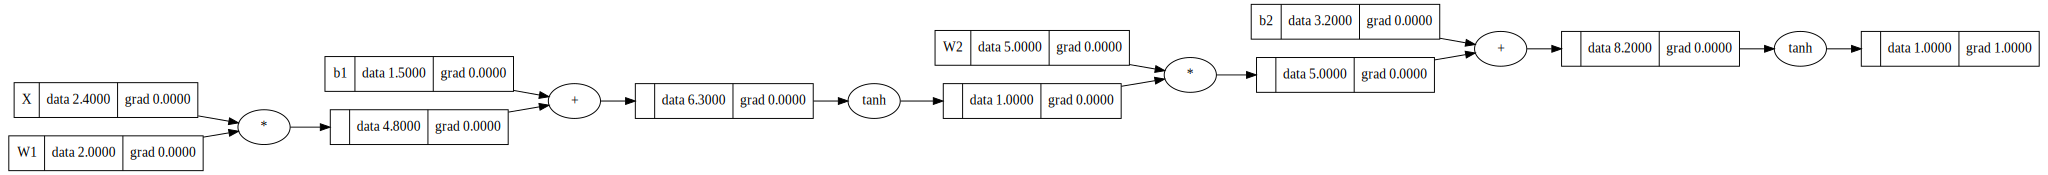

In [38]:
draw_dot(A2)